In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=42)

### Defining the Parameters

In [ ]:
fs = 44100 # frequency
T = 0.25 # seconds to simulate
t = np.arange(0, T, 1/fs) # time grid

In [ ]:
# For a single clap, we use the function s(t). I am modeling one waveform as an exponential decaying sinusoid.
# s(t) = exp(-t/tau) * (t >= 0) 

tau_decay = 0.025 # 25 ms decay
s = np.exp(-t/tau_decay)

array([1.00000000e+00, 9.99093382e-01, 9.98187585e-01, ...,
       4.55236352e-05, 4.54823627e-05, 4.54411275e-05])

In [ ]:
# Gaussian Jitter Kernel (in seconds), narrow compared to s(t) support
sigma_tau = 0.0008 # 0.8 ms std timing jitter 
jitter_support = int(np.ceil(4 * sigma_tau * fs)) # +/- 4 sigma
k = np.arange(-jitter_support, jitter_support + 1) # represents a sequence of integer time shifts
g = np.exp( - (k / fs) ** 2 / (2*sigma_tau**2)) # Our Discrete Gaussian Curve
g = g / g.sum()

# Here the variable g represents our discrete Gaussian curve, which is the probability
# of a person clapping at that moment of time k. 

Let me make the assumptions of the model so far clear : 
- We are assuming that the clap of each person repersents a random variable. (X_i)
- X_i = N( 0, sigma_tau**2 ). This means that each random variable represents a normal distribution centered around 0 with a standard diviation of sigma_tau( or 0.0008). 
- I am assuming sigma_tau = 0.8 ms, which would mean that there is a very small difference in each persons clapp timing ( the audience is almost in unison ).

In [14]:
E_A = 1.0 # mean amplitude
m = np.convolve(s, g, mode='same')*E_A

By the end, *m* here is supposed to represent a discrete form of the final predicted waveform. We can see this in the following diagram. 

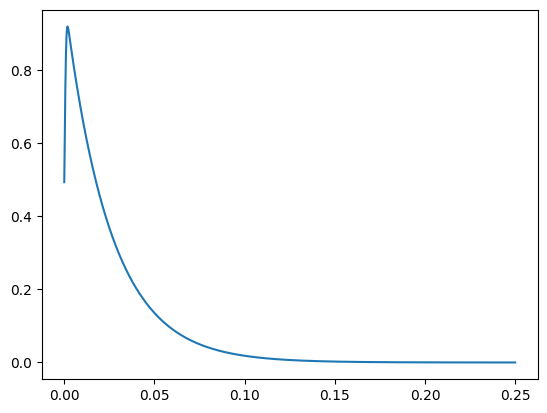

In [ ]:
plt.plot(t, m)
plt.title('Predicted Mean Waveform of Audience Clap')
plt.show()

### Helper to Simulate an audience clap

The whole objective of this section is to build a helper function that would output an waveform given the number of people in the audience and the type of amplitude of claps. 

In [102]:
# simulate_audience_clap(int N, str amplitudes) -> np.ndarray X
# Function : This function simulates a discrete waveform X(t) representing the summed audience clap wavefom
#          : given the number of people N in the audience and the type 
#          : of amplitude distribution for each clap.

In [ ]:
def simulate_audience_waveform(N, amplitudes='lognormal'):
    
    # the variable tau is used to represent miniscule time shifts in each person's clap.
    # tau_samples represents an index shift in the discrete waveform.
    tau = rng.normal(loc=0., scale=sigma_tau, size=N)
    tau_samples = np.round(tau * fs).astype(int)

    # This part of the function constructs how loud each person's clap is.
    # By the end of this section, we define the variable A, which represents the amplitude of each person's clap.
    # There are three options for amplitude distributions: 
    #                  1.'lognormal'  : meaning A follows a lognormal distribution
    #                  2.'normal_pos' : meaning A follows a normal distribution such that A >= 0
    #                  3. 'constant'  : everyone claps with the same amplitude of 1.0
    if amplitudes == 'lognormal':
        sigma_ln = 0.30
        mu_ln = np.log(E_A) - 0.5 * sigma_ln**2
        A = rng.lognormal(mean=mu_ln, sigma=sigma_ln, size=N)
    elif amplitudes == 'normal_pos':
        A = np.maximum(0, rng.normal(loc=E_A, scale=0.25, size=N))
    else : 
        A = np.ones(N)

    X = np.zeros_like(t, dtype=float) # X is the final waveform from the audience clapping.
    L = len(t)
    Ls = len(s)

    # In this final section of code, we build the final wavefrom X by summing each person's clap.
    center = 0  # s is already causal starting at 0, so shift by tau_samples
    for Ai, shift in zip(A, tau_samples):
        # We need to add s shifted by 'shift' samples
        start = max(0, shift)
        end   = min(L, shift + Ls)
        s_start = max(0, -shift)
        s_end   = s_start + (end - start)
        if start < end:
            X[start:end] += Ai * s[s_start:s_end]

    return X


### Monte Carlo to show CLT and Scaling aand mean-shape convergence.

The entire purpose of this section is to bring everything we have done so far together. In this section, we are going to run a bunch of simulations using Monte Carlo experiment. By the end, we want to prove the following : 

1. the mean crowd waveform matches the theoretical wavefrom *N * m* (Law of Large Numbers), and 
2. the relative randomness at the peak shrinks like 1 / √N. (CLT)

In [105]:
N_list = [20, 50, 100, 200]
B = 200  # number of repetitions per N (increase if you want tighter estimates)

peak_idx = np.argmax(m)  # evaluate fluctuations at theoretical mean peak
records = []             # for pandas

# For plotting mean vs theory
mean_waveforms = {}

for N in N_list:
    peaks = []
    coeff_var_over_time = []  # optional; we will compute CV at the peak
    all_runs_peak = []
    
    # Accumulate for mean/sd over time (optional, but useful)
    acc = np.zeros_like(t, dtype=float)
    acc2 = np.zeros_like(t, dtype=float)
    
    for b in range(B):
        X = simulate_audience_waveform(N)
        acc += X
        acc2 += X**2
        
        # store peak amplitude and value at theoretical-peak location
        peaks.append(X.max())
        all_runs_peak.append(X[peak_idx])
    
    # empirical mean and sd over runs
    mean_X = acc / B
    var_X  = acc2 / B - mean_X**2
    sd_X   = np.sqrt(np.maximum(var_X, 0.0))
    
    mean_waveforms[N] = mean_X
    
    # Coefficient of variation at the peak
    cv_peak = sd_X[peak_idx] / (mean_X[peak_idx] + 1e-12)
    
    records.append({
        "N": N,
        "mean_peak": float(mean_X[peak_idx]),
        "sd_peak": float(sd_X[peak_idx]),
        "cv_peak": float(cv_peak),
        "theory_mean_peak": float(N * m[peak_idx]),
        "ratio_to_theory": float((mean_X[peak_idx]) / (N * m[peak_idx] + 1e-12))
    })

df_summary = pd.DataFrame.from_records(records).sort_values("N").reset_index(drop=True)


Let me explain what we are doing here : 

      - We are running the Monte Carlo Experiment with four different values of N = [20, 50, 100, 200]
      - For each value of N, we are running the simulation (aka simulate_audience_waveform) 200 times. 
      - After each of the simulations, we store the following values : 
                          - peak of each simulation
                          - amplitude at fixed point in time ( we choose the peak of our theoretical mean to be the choose fixed point in time).
      - By the end of each run, we have emperical mean and sd over runs. 
      - We store the values for each run of Monte Carlo in the records list. 

In [108]:
df_summary

,N,mean_peak,sd_peak,cv_peak,theory_mean_peak,ratio_to_theory
0,20,18.349751,1.365034,0.074390,18.382632,0.998211
1,50,46.287258,2.062680,0.044563,45.956581,1.007195
2,100,91.587517,3.123764,0.034107,91.913161,0.996457
3,200,183.275628,4.161686,0.022707,183.826323,0.997004


Note the ratio_to_theory column. For all cases it is approaching the value of 1. This shows that our predictions and simulations have been very similar. 

### Plots 

Now is the most crucial time. Now is the time to visualize the entire process and see our findings. 

Firstly lets look at mean waveforms *v/s* theory waveform. 

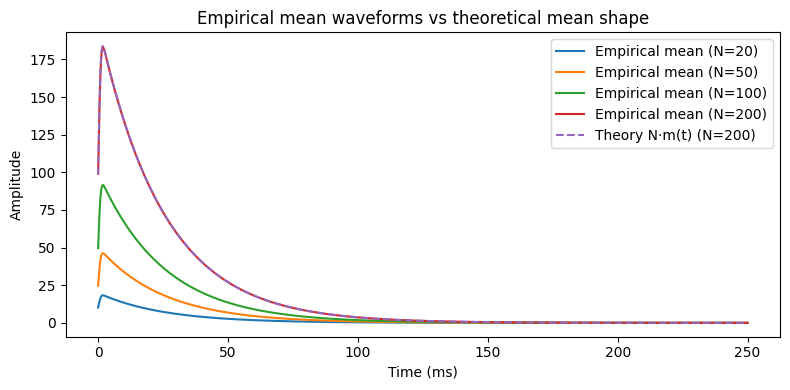

In [118]:
plt.figure(figsize=(8, 4))

for N in N_list:
    plt.plot(t*1000, mean_waveforms[N], label=f"Empirical mean (N={N})")


plt.plot(t*1000, m * max(N_list), linestyle="--", label=f"Theory N·m(t) (N={max(N_list)})")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Empirical mean waveforms vs theoretical mean shape")
plt.legend()
plt.tight_layout()
plt.show()

The Next graph will prove the relation 
                                      CV ~ (1 / √N). 

In the variable df_summary, we have column cv_peak which we will use for the mean cv 
for each value of N. 

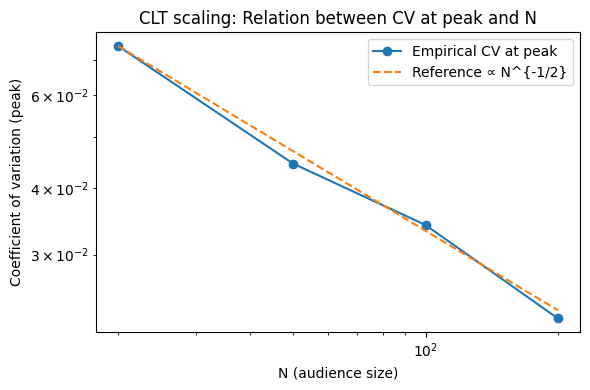

In [117]:
Ns = df_summary["N"].to_numpy()
cv = df_summary["cv_peak"].to_numpy()

plt.figure(figsize=(6, 4))
plt.loglog(Ns, cv, marker="o", linestyle="-", label="Empirical CV at peak")
# reference line ~ N^{-1/2} through first point
ref = cv[0] * np.sqrt(Ns[0] / Ns)
plt.loglog(Ns, ref, linestyle="--", label="Reference ∝ N^{-1/2}")
plt.xlabel("N (audience size)")
plt.ylabel("Coefficient of variation (peak)")
plt.title("CLT scaling: Relation between CV at peak and N")
plt.legend()
plt.tight_layout()
plt.show()

With these two last graphs, we have proved that for large values of N, we see that the mean waveform resembeles similar distribution to Normal Distributions centered around 0, with sigma  ( standard deviation ) dependent on N. 